### Libraries

In [ ]:
# Load Libraries
import os
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
%matplotlib inline

### Preprocessing
1. Import data
2. Label data
3. Split data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load images
def load_im():
    input_im, input_label = [], []
    resize = (224, 224)
    # Loop in folders
    for dirname, _, filenames in os.walk('drive/MyDrive/proj dataset/archive'):
        for filename in filenames:
            photo_path = os.path.join(dirname, filename)
            photo_class = dirname.split('/')[-1]
            try:
                read_im = cv2.imread(photo_path)
                input_im.append(cv2.resize(read_im, resize))
                # potholes == 1
                if photo_class == 'potholes':
                    input_label.append(1)
                # normal == 0
                elif photo_class == 'normal':
                    input_label.append(0)
            except:
                print(photo_path)
    # return list of images and another list of correponding labels
    return input_im, input_label

input_im, input_label = load_im()
copyinput_im,copyinput_label=input_im,input_label

drive/MyDrive/proj dataset/archive/normal/226.jpg


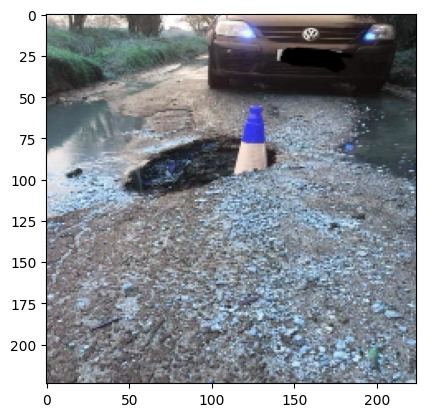

1


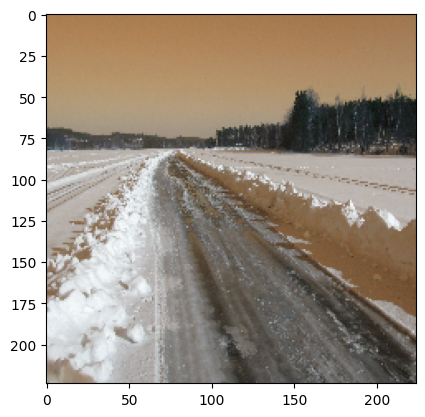

0


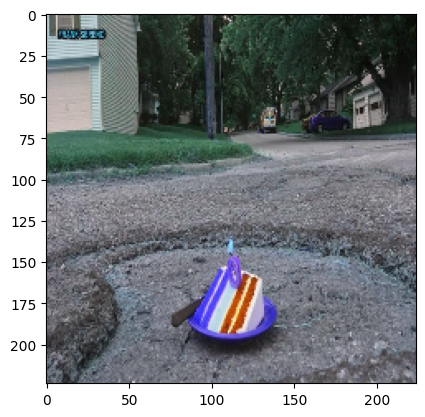

1


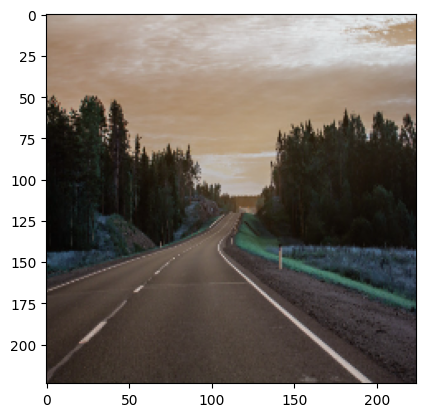

0


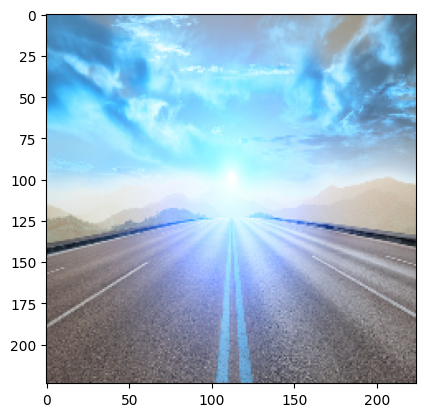

0


In [ ]:
# Checking code: Print photo and class
index_set = np.random.choice(len(input_label), size = 5, replace = False)
for index in index_set:
    # show images
    plt.imshow(input_im[index])
    plt.show()
    # show label
    print(input_label[index])

### Image augmentation
Applied to training set only
1. Horizontal Flipping
2. Clockwise and Anti-clockwise Rotation by 30 degree

In [ ]:
# Train/Test split
def train_test_split(test_prop, input_im, input_label):
    # Random sampling of index
    test_size = int(np.floor(test_prop * len(input_label)))
    test_index = np.random.choice(len(input_label), size = test_size, replace = False)
    # Split
    train_x, test_x, train_y, test_y = np.delete(input_im, test_index, axis = 0), np.take(input_im, test_index, axis = 0), np.delete(input_label, test_index, axis = 0), np.take(input_label, test_index, axis = 0)
    # Return train and test sets for both images and labels
    return train_x, test_x, train_y, test_y, test_index

# 80/20 split for small data set
test_prop = 0.2
train_x, test_x, train_y, test_y, test_index = train_test_split(test_prop, input_im, input_label)

In [ ]:
def append_im(input_im, input_label, im_iterator):
    input_label_n = input_label.copy()
    input_im_n = input_im.copy()
    for i in range(len(im_iterator)):
        im = im_iterator[i]
        im = im.astype('uint8')
        im_lbl = [input_label[i]]
        input_im_n = np.append(input_im_n, im, axis = 0)
        input_label_n = np.append(input_label_n, im_lbl, axis = 0)
    return input_im_n, input_label_n

In [ ]:
# Flipping
flip_data_generator = ImageDataGenerator(horizontal_flip = True)
im_iterator = flip_data_generator.flow(train_x, batch_size = 1, shuffle = False)
input_im_n, input_label_n = append_im(train_x, train_y, im_iterator)

#Rotation - 30 deg 
#rotate_data_generartor = ImageDataGenerator(rotation_range = 30)
#im_iterator = rotate_data_generartor.flow(train_x, batch_size = 1, shuffle = False)
#input_im_n, input_label_n = append_im(input_im_n, input_label_n, im_iterator)

#Rotation - -30 deg 
#rotate_data_generartor = ImageDataGenerator(rotation_range = 330)
#im_iterator = rotate_data_generartor.flow(train_x, batch_size = 1, shuffle = False)
#input_im_n, input_label_n = append_im(input_im_n, input_label_n, im_iterator)

In [ ]:
# Reshape
nx, ny, nz = train_x.shape[1], train_x.shape[2], train_x.shape[3]
train_x_nn, test_x_nn = input_im_n, test_x
train_x = input_im_n.reshape((input_im_n.shape[0], nx * ny * nz)) / 255
test_x = test_x.reshape((test_x.shape[0], nx * ny * nz)) / 255
train_y = input_label_n.reshape((input_label_n.shape[0], 1)) 
test_y = test_y.reshape((test_y.shape[0], 1)) 

In [ ]:
# Dimensionality reduction - Full PCA- reduces the number of features in a dataset by finding the linear combinations of features that explain the most variance.
im_pca = PCA()
im_pca.fit(train_x)
variance_explained_list = im_pca.explained_variance_ratio_.cumsum()
print(variance_explained_list)

[0.19515554 0.31411203 0.36803591 ... 1.         1.         1.        ]


In [ ]:
test_x_pca = im_pca.transform(test_x)
train_x_pca = im_pca.transform(train_x)

In [ ]:
# Implementing Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Creating the random forest model
rf = RandomForestClassifier(max_depth=8, random_state=0)

# Training the model
rf.fit(train_x_pca, train_y)

# Predicting on the test data
predictions = rf.predict(test_x_pca)

# Calculating the accuracy of the model
accuracy = accuracy_score(test_y, predictions)

# Printing the accuracy
print(accuracy)

<ipython-input-11-70bf8b280095>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_x_pca, train_y)


0.5955882352941176


In [ ]:
# Loading the image
image = cv2.imread('drive/MyDrive/proj dataset/archive/potholes/3.jpg')

#plt.imshow(cv2.imread("drive/MyDrive/proj dataset/archive/potholes/105.jpg"))
# Preprocessing the image
image = cv2.resize(image, (224, 224))

# Dimensionality reduction - Full PCA
im_pca = PCA()
im_pca.fit(train_x)
test_x_pca = im_pca.transform(image.reshape(1, 224*224*3)/255)

# Predicting whether the image contains pothole or not
prediction = rf.predict(test_x_pca)

# Printing the prediction
#print(prediction)


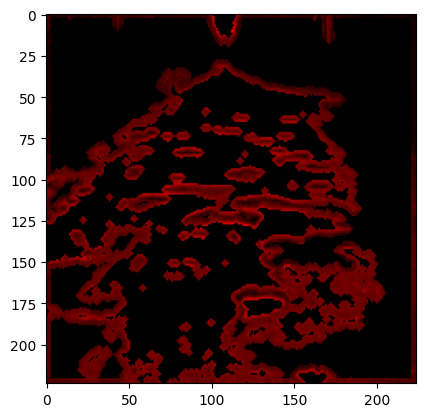

Potholes


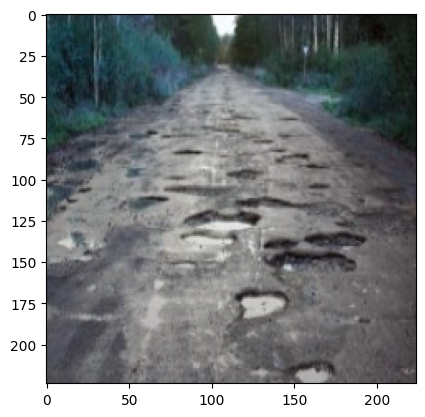

In [ ]:
if prediction[0]==0:
  print("Normal")
else:
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Apply thresholding to detect the boundaries of the pothole
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  # Find contours of the pothole
  contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]

  # Create a mask of the pothole
  mask = np.zeros(image.shape, np.uint8)
  cv2.drawContours(mask, contours, -1, (255,0,0), 3)

  # Use the mask to mark the area of the pothole
  output = cv2.bitwise_and(image, mask)
    
  # Show the output
  plt.imshow(output)
  plt.show()
  print("Potholes")
plt.imshow(image)

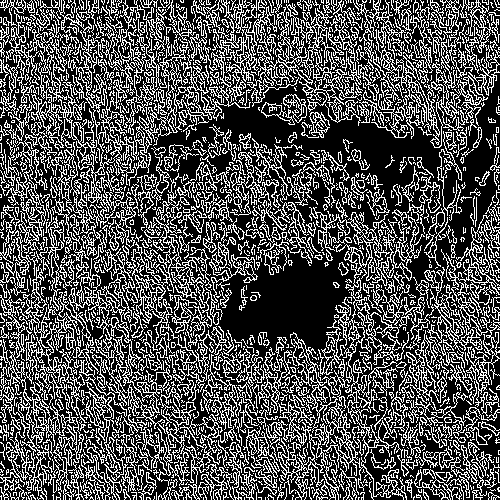

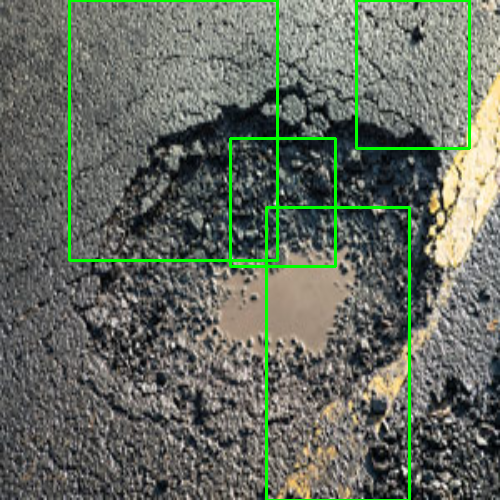

In [ ]:
from google.colab.patches import cv2_imshow
# Marking the region in the image that contains pothole
#Reading the image

img = cv2.imread('drive/MyDrive/proj dataset/archive/potholes/5.jpg')
img=cv2.resize(img, (500, 500))
#Converting the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Finding the edges in the image using Canny edge detection
edges = cv2.Canny(gray,50,150,apertureSize = 3)#Finding the contours in the image













contours,hierarchy = cv2.findContours(edges, 1, 2)
#Looping throught the contours
for cnt in contours:
  #Creating a rectangle around the contours
  x,y,w,h = cv2.boundingRect(cnt)


  width_relative = img.shape[0]/w
  height_relative = img.shape[1]/h
  #Checking if the size of the hole is greater than the specified size
  if w>100 and h>100:
  #if width_relative > 1 and height_relative > 1:
  #Drawing the rectangle
       cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    #Displaying the output image
cv2_imshow(edges)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()